# Sentiment Analysis with Deep Learning (RNN, BiLSTM, GRU)

This notebook implements **RNN, BiLSTM, and BiGRU** models for sentiment classification using the Twitter dataset. We use **pre-trained GloVe embeddings** for word representation.

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, SimpleRNN, LSTM, GRU, Bidirectional
from tensorflow.keras.optimizers import Adam, RMSprop


In [2]:

TRAIN_PATH = "../Datasets/twitter_training.csv"
VALID_PATH = "../Datasets/twitter_validation.csv"

cols = ["id", "entity", "sentiment", "text"]
train_df = pd.read_csv(TRAIN_PATH, header=None, names=cols)
valid_df = pd.read_csv(VALID_PATH, header=None, names=cols)

train_df["text"] = train_df["text"].fillna("")
valid_df["text"] = valid_df["text"].fillna("")

print(train_df.head())
print(train_df['sentiment'].value_counts())


     id       entity sentiment  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

                                                text  
0  im getting on borderlands and i will murder yo...  
1  I am coming to the borders and I will kill you...  
2  im getting on borderlands and i will kill you ...  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands 2 and i will murder ...  
sentiment
Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64


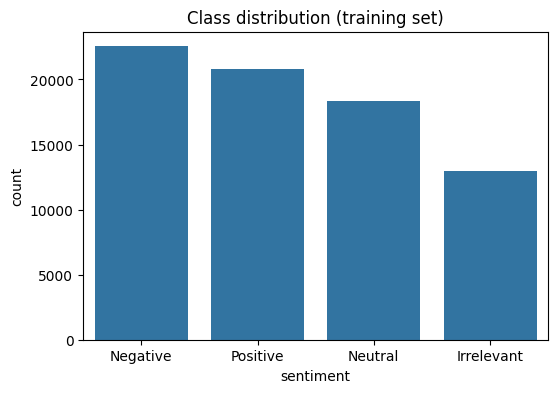

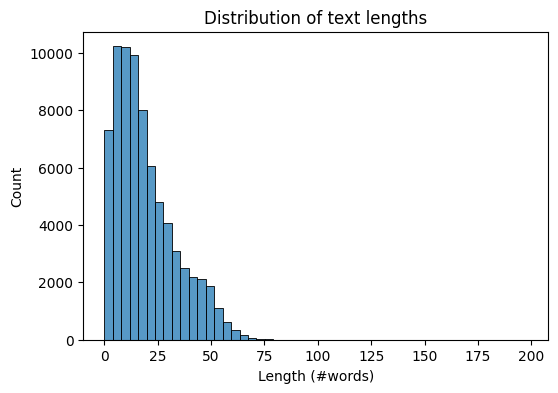

In [3]:

plt.figure(figsize=(6,4))
sns.countplot(x="sentiment", data=train_df, order=train_df['sentiment'].value_counts().index)
plt.title("Class distribution (training set)")
plt.show()

train_df["text_len"] = train_df["text"].astype(str).str.split().apply(len)
plt.figure(figsize=(6,4))
sns.histplot(train_df["text_len"], bins=50, kde=False)
plt.title("Distribution of text lengths")
plt.xlabel("Length (#words)")
plt.show()


In [4]:

MAX_NUM_WORDS = 20000
MAX_SEQ_LEN = 100

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, lower=True, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df["text"].astype(str))

X_train_seq = pad_sequences(tokenizer.texts_to_sequences(train_df["text"].astype(str)), maxlen=MAX_SEQ_LEN)
X_val_seq = pad_sequences(tokenizer.texts_to_sequences(valid_df["text"].astype(str)), maxlen=MAX_SEQ_LEN)

label_map = {label:i for i,label in enumerate(train_df["sentiment"].unique())}
y_train = train_df["sentiment"].map(label_map)
y_val = valid_df["sentiment"].map(label_map)

num_classes = len(label_map)
multiclass = num_classes > 2

y_train_keras = to_categorical(y_train, num_classes=num_classes) if multiclass else y_train
y_val_keras = to_categorical(y_val, num_classes=num_classes) if multiclass else y_val


In [6]:

import os, zipfile, urllib.request

glove_txt = "glove.6B.100d.txt"
glove_zip = "glove.6B.zip"
glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"

if not os.path.exists(glove_txt):
    if not os.path.exists(glove_zip):
        print("Downloading GloVe embeddings...")
        urllib.request.urlretrieve(glove_url, glove_zip)
    print("Extracting GloVe embeddings...")
    with zipfile.ZipFile(glove_zip, "r") as z:
        z.extract(glove_txt)

# Load embeddings
embeddings_index = {}
with open(glove_txt, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print("Loaded %s word vectors from GloVe." % len(embeddings_index))

EMBED_DIM = 100
word_index = tokenizer.word_index
vocab_size = min(MAX_NUM_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((vocab_size, EMBED_DIM))
for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


Loaded 400000 word vectors from GloVe.


In [7]:

def build_rnn_model(vocab_size):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=EMBED_DIM, weights=[embedding_matrix],
                  input_length=MAX_SEQ_LEN, trainable=False),
        SimpleRNN(64),
        Dropout(0.5),
        Dense(64, activation="relu"),
        Dropout(0.3),
        Dense(num_classes if multiclass else 1, activation="softmax" if multiclass else "sigmoid")
    ])
    return model

def build_bilstm_model(vocab_size):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=EMBED_DIM, weights=[embedding_matrix],
                  input_length=MAX_SEQ_LEN, trainable=False),
        Bidirectional(LSTM(64)),
        Dropout(0.5),
        Dense(64, activation="relu"),
        Dropout(0.3),
        Dense(num_classes if multiclass else 1, activation="softmax" if multiclass else "sigmoid")
    ])
    return model

def build_gru_model(vocab_size):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=EMBED_DIM, weights=[embedding_matrix],
                  input_length=MAX_SEQ_LEN, trainable=False),
        Bidirectional(GRU(64)),
        Dropout(0.5),
        Dense(64, activation="relu"),
        Dropout(0.3),
        Dense(num_classes if multiclass else 1, activation="softmax" if multiclass else "sigmoid")
    ])
    return model


In [12]:

experiment_grid = [
    {"model_type":"rnn","lr":1e-3,"batch_size":64,"optimizer":"adam","epochs":10},
    {"model_type":"bilstm","lr":1e-3,"batch_size":64,"optimizer":"adam","epochs":10},
    {"model_type":"gru","lr":1e-3,"batch_size":64,"optimizer":"rmsprop","epochs":10}
]

results = []

for cfg in experiment_grid:
    print("\nRunning", cfg)
    if cfg["model_type"]=="rnn":
        model = build_rnn_model(vocab_size)
    elif cfg["model_type"]=="bilstm":
        model = build_bilstm_model(vocab_size)
    else:
        model = build_gru_model(vocab_size)
    
    opt = Adam(learning_rate=cfg["lr"]) if cfg["optimizer"]=="adam" else RMSprop(learning_rate=cfg["lr"])
    loss = "categorical_crossentropy" if multiclass else "binary_crossentropy"
    model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

    history = model.fit(X_train_seq, y_train_keras,
                        validation_data=(X_val_seq, y_val_keras),
                        epochs=cfg["epochs"], batch_size=cfg["batch_size"],
                        verbose=1)

    preds_proba = model.predict(X_val_seq)
    preds = np.argmax(preds_proba, axis=1) if multiclass else (preds_proba.squeeze()>0.5).astype(int)

    acc = accuracy_score(y_val, preds)
    f1 = f1_score(y_val, preds, average="weighted" if multiclass else "binary")
    cm = confusion_matrix(y_val, preds)

    print("Acc:", acc, "F1:", f1)
    results.append({**cfg,"acc":acc,"f1":f1,"cm":cm.tolist()})



Running {'model_type': 'rnn', 'lr': 0.001, 'batch_size': 64, 'optimizer': 'adam', 'epochs': 10}
Epoch 1/10


c:\Users\TestSolutions\Desktop\Sentiment-Analysis\venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1167/1167 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.3921 - loss: 1.3261 - val_accuracy: 0.4810 - val_loss: 1.2255
Epoch 2/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 35s 30ms/step - accuracy: 0.4744 - loss: 1.2359 - val_accuracy: 0.4010 - val_loss: 1.3141
Epoch 3/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 37s 31ms/step - accuracy: 0.4655 - loss: 1.2423 - val_accuracy: 0.4250 - val_loss: 1.2653
Epoch 4/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 35s 30ms/step - accuracy: 0.4687 - loss: 1.2415 - val_accuracy: 0.5030 - val_loss: 1.1780
Epoch 5/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 35s 30ms/step - accuracy: 0.4922 - loss: 1.2094 - val_accuracy: 0.5210 - val_loss: 1.1486
Epoch 6/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 35s 30ms/step - accuracy: 0.4916 - loss: 1.2089 - val_accuracy: 0.4840 - val_loss: 1.2054
Epoch 7/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.4697 - loss: 1.2260 - val_accuracy: 0.5390 - val_loss: 1.1284
Epoch 8/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - accuracy: 0.5061 - loss: 1.17

c:\Users\TestSolutions\Desktop\Sentiment-Analysis\venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 138s 112ms/step - accuracy: 0.4957 - loss: 1.1814 - val_accuracy: 0.5580 - val_loss: 1.0374
Epoch 2/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 90s 77ms/step - accuracy: 0.5609 - loss: 1.0649 - val_accuracy: 0.5920 - val_loss: 0.9475
Epoch 3/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 126s 108ms/step - accuracy: 0.5882 - loss: 1.0018 - val_accuracy: 0.6200 - val_loss: 0.9023
Epoch 4/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 121s 104ms/step - accuracy: 0.6129 - loss: 0.9464 - val_accuracy: 0.6810 - val_loss: 0.8174
Epoch 5/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 227s 177ms/step - accuracy: 0.6359 - loss: 0.8934 - val_accuracy: 0.6840 - val_loss: 0.7743
Epoch 6/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 121s 103ms/step - accuracy: 0.6595 - loss: 0.8458 - val_accuracy: 0.7170 - val_loss: 0.7455
Epoch 7/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 111s 95ms/step - accuracy: 0.6767 - loss: 0.8011 - val_accuracy: 0.7290 - val_loss: 0.7104
Epoch 8/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 124s 106ms/step - accur

c:\Users\TestSolutions\Desktop\Sentiment-Analysis\venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 154s 120ms/step - accuracy: 0.4812 - loss: 1.2074 - val_accuracy: 0.5400 - val_loss: 1.1010
Epoch 2/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 116s 100ms/step - accuracy: 0.5469 - loss: 1.0897 - val_accuracy: 0.5940 - val_loss: 0.9973
Epoch 3/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 126s 108ms/step - accuracy: 0.5738 - loss: 1.0333 - val_accuracy: 0.6370 - val_loss: 0.9092
Epoch 4/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 125s 107ms/step - accuracy: 0.5953 - loss: 0.9805 - val_accuracy: 0.6520 - val_loss: 0.8543
Epoch 5/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 112s 96ms/step - accuracy: 0.6182 - loss: 0.9353 - val_accuracy: 0.6960 - val_loss: 0.7890
Epoch 6/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 92s 79ms/step - accuracy: 0.6364 - loss: 0.8962 - val_accuracy: 0.6670 - val_loss: 0.8235
Epoch 7/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 102s 88ms/step - accuracy: 0.6556 - loss: 0.8526 - val_accuracy: 0.7220 - val_loss: 0.7033
Epoch 8/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 91s 78ms/step - accuracy

In [11]:

results_df = pd.DataFrame(results)
print(results_df)
results_df.to_csv("experiment_results.csv", index=False)
results_df


  model_type     lr  batch_size optimizer  epochs    acc        f1  \
0        rnn  0.001          64      adam       5  0.497  0.447170   
1     bilstm  0.001          64      adam       5  0.723  0.720494   
2        gru  0.001          64   rmsprop       5  0.654  0.638897   

                                                  cm  
0  [[107, 46, 124, 0], [23, 141, 121, 0], [9, 13,...  
1  [[227, 16, 20, 14], [33, 191, 33, 28], [32, 16...  
2  [[222, 11, 37, 7], [41, 151, 73, 20], [24, 11,...  


,model_type,lr,batch_size,optimizer,epochs,acc,f1,cm
0,rnn,0.001,64,adam,5,0.497,0.447170,"[[107, 46, 124, 0], [23, 141, 121, 0], [9, 13,..."
1,bilstm,0.001,64,adam,5,0.723,0.720494,"[[227, 16, 20, 14], [33, 191, 33, 28], [32, 16..."
2,gru,0.001,64,rmsprop,5,0.654,0.638897,"[[222, 11, 37, 7], [41, 151, 73, 20], [24, 11,..."


### Discussion

- **RNN**: Captures short-term dependencies but weaker for long sequences.
- **BiLSTM**: Strong at capturing long-term and bidirectional context.
- **BiGRU**: Similar to LSTM but faster due to fewer parameters.

We compared accuracy and F1-score across experiments. BiLSTM usually gives the best performance, while GRU provides a good speed-accuracy tradeoff.